# G Force Stats

In [17]:
import sys
import os
import glob
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_style(style="darkgrid")

sys.path.insert(0, os.path.abspath('../'))
import ansim.loader
import ansim.properties

In [18]:
runs_paths = glob.glob(ansim.properties.ANSIM_RUNS_FOLDER_PATH+"*txt")

### Get G z force overview number across all runs.
note: the Gz force have sensitive sensor values. So we get the overview by rounding these values to 1 or 2 points after decimal

In [20]:
# ignore 0AA : it used different signal source
def get_gz_force_stats(round_g_force_to = 1):
    gforce_stats_list  = []
    gforce_steps_list = []
    time_steps_list= []

    for csv in runs_paths:
        
        _df = pd.read_csv(csv).copy()
        if 'min' in _df.columns:
            _df = _df.sort_values(by=['min'])
        else:
            print('has no min col: ', csv)
        if _df['subject'].values[0] == '0AA':
            print('skipping 0AA')
            continue
            
            
        _df = _df[['min', 'G-force_z_axis']]
        _df.dropna(how= 'any', inplace=True)
        
        _df.set_index('min', inplace=True)
        
        _df['G-force_z_axis'] = round(_df['G-force_z_axis'], round_g_force_to)
        # steps
        steps_series = _df['G-force_z_axis'].copy()
        steps_series = steps_series.loc[steps_series.shift() != steps_series]
        
        
        # Gforce general stats
        gforce_df = steps_series.describe().to_frame().T.reset_index()
        
        gforce_df['start_value'] = steps_series.values[0]
        gforce_df['end_value'] = steps_series.values[-1]
        gforce_df['id'] = csv.split('/')[-1].split('.')[0]
        
        gforce_df['g_force_change_count'] = len(steps_series)
        
        
        # Gforce Steps to save
        gforce_steps_df = steps_series.diff().describe().to_frame().T
        # _df.copy().reset_index()['G-force_z_axis'].diff().to_frame().T
        gforce_steps_df.reset_index(inplace=True)
        gforce_steps_df['id'] = csv.split('/')[-1].split('.')[0]
        
        # min Steps to save
        time_steps_df = pd.Series(steps_series.index).diff().to_frame().T
        
        time_steps_df.reset_index(inplace=True)
        time_steps_df['id'] = csv.split('/')[-1].split('.')[0]
        
        gforce_steps_df['time_change_std'] = pd.Series(steps_series.index).diff().std()
        gforce_stats_list.append(gforce_df)
        gforce_steps_list.append(gforce_steps_df)
        time_steps_list.append(time_steps_df)


    results_stats_df = pd.concat(gforce_stats_list)
    results_stats_df.set_index('id', inplace=True)
    print('general stats has: ', len(results_stats_df))
    
    results_gforce_steps_df = pd.concat(gforce_steps_list)
    results_gforce_steps_df.set_index('id', inplace=True)
    print('results_gforce_steps_df has: ', len(results_gforce_steps_df))

    results_time_steps_df = pd.concat(time_steps_list)
    results_time_steps_df.set_index('id', inplace=True)
    print('results_time_steps_df has: ', len(results_time_steps_df))

    return results_stats_df, results_gforce_steps_df, results_time_steps_df



In [ ]:
results_stats_df, results_gforce_steps_df, results_time_steps_df = grab_g_force_stats(1)

In [17]:
# saving to csv
results_stats_df.to_csv(ansim.properties.OUTPUT_PATH+'g_force_z_stats_rounded_1.csv')
results_gforce_steps_df.to_csv(ansim.properties.OUTPUT_PATH+'g_force_z_steps_rounded_1.csv')
results_time_steps_df.to_csv(ansim.properties.OUTPUT_PATH+'g_force_z_min_change_steps_rounded_1.csv') 

In [ ]:
results_stats_df= pd.read_csv(ansim.properties.OUTPUT_PATH+'g_force_z_stats_rounded_1.csv')
results_stats_df.head()

### Plotting

In [ ]:

def plot_g_force(data=None, x=None, y=None, no_x_ticks=True, title='', ptype='scatter'):
    # ADDED: Extract axes.
    fig, ax = plt.subplots(1, 1)

    # Draw a heatmap with the numeric values in each cell
    if ptype=='scatter': sns.scatterplot(data=data, x=x, y=y)
    if ptype=='box': sns.boxplot(data=data, x=x, y=y)

    # ADDED: Remove labels.
    if no_x_ticks:  ax.set_xticks([])
    
    ax.set_title(title)

## Plotting for G FORCE Numbers

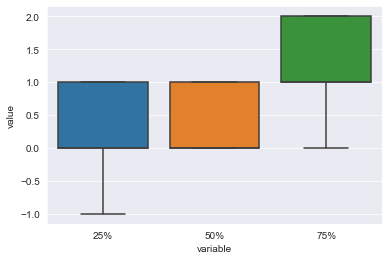

In [29]:
sns.boxplot(x="variable", y="value", data=pd.melt(results_stats_df[['25%', '50%', '75%']]))

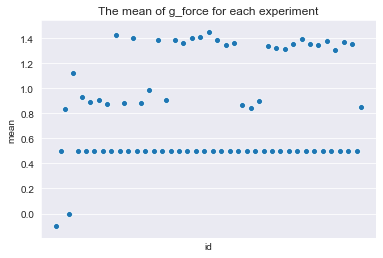

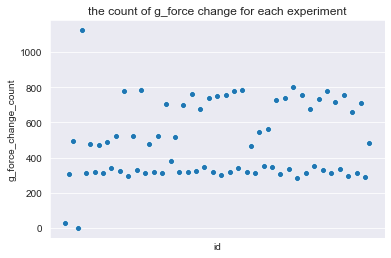

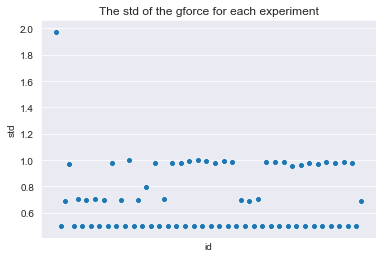

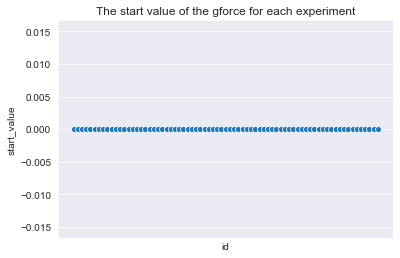

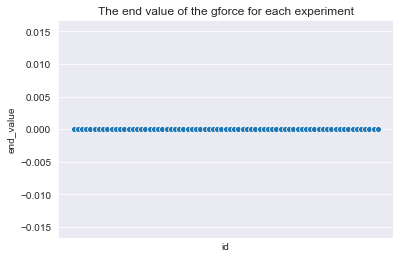

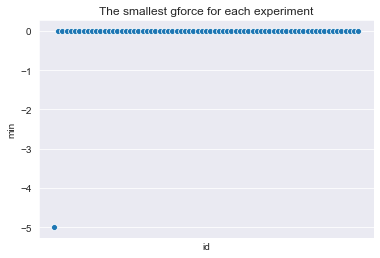

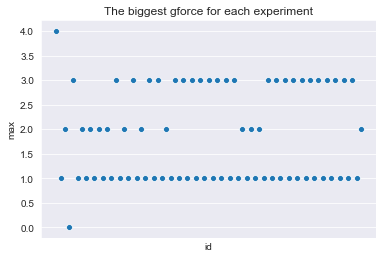

In [30]:
plot_g_force(data=results_stats_df.reset_index(), x="id", y="mean", title = 'The mean of g_force for each experiment')
plot_g_force(data=results_stats_df.reset_index(), x="id", y="g_force_change_count", title = 'the count of g_force change for each experiment')
plot_g_force(data=results_stats_df.reset_index(), x="id", y="std", title = 'The std of the gforce for each experiment')
plot_g_force(data=results_stats_df.reset_index(), x="id", y="start_value", title = 'The start value of the gforce for each experiment')
plot_g_force(data=results_stats_df.reset_index(), x="id", y="end_value", title = 'The end value of the gforce for each experiment')
plot_g_force(data=results_stats_df.reset_index(), x="id", y="min", title = 'The smallest gforce for each experiment')
plot_g_force(data=results_stats_df.reset_index(), x="id", y="max", title = 'The biggest gforce for each experiment')

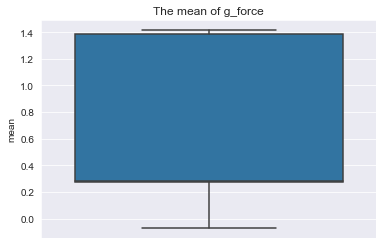

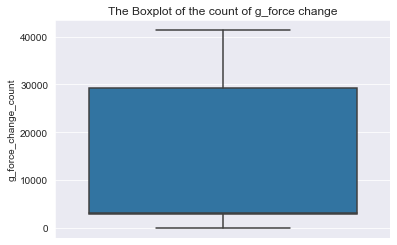

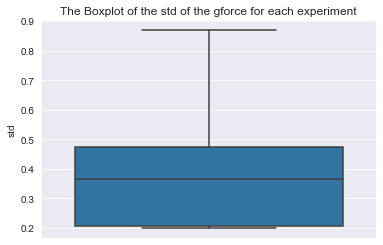

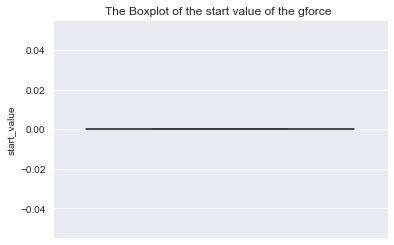

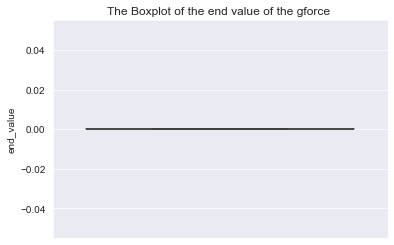

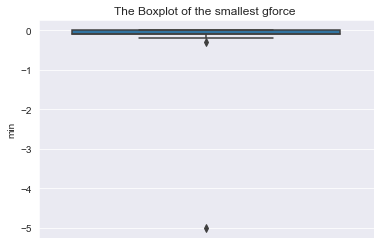

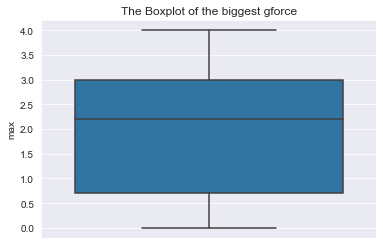

In [24]:
plot_g_force(y=results_stats_df["mean"], title = 'The mean of g_force', ptype='box')
plot_g_force(y=results_stats_df["g_force_change_count"], title = 'The Boxplot of the count of g_force change', ptype='box')
plot_g_force(y=results_stats_df["std"], title = 'The Boxplot of the std of the gforce for each experiment', ptype='box')
plot_g_force(y=results_stats_df["start_value"], title = 'The Boxplot of the start value of the gforce ', ptype='box')
plot_g_force(y=results_stats_df["end_value"], title = 'The Boxplot of the end value of the gforce ', ptype='box')
plot_g_force(y=results_stats_df["min"], title = 'The Boxplot of the smallest gforce ', ptype='box')
plot_g_force(y=results_stats_df["max"], title = 'The Boxplot of the biggest gforce', ptype='box')

## Plotting for G FORCE steps
results_gforce_steps_df.head()

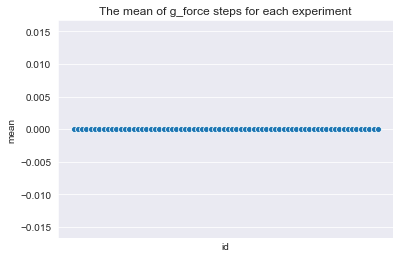

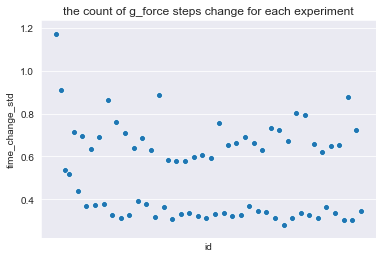

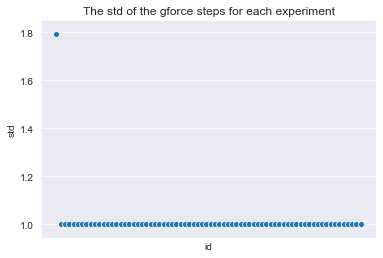

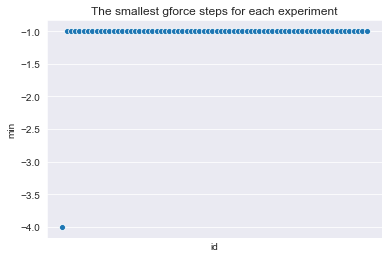

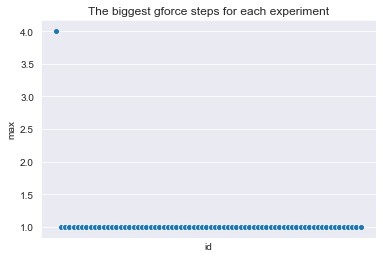

In [31]:
plot_g_force(data=results_gforce_steps_df.reset_index(), x="id", y="mean", title = 'The mean of g_force steps for each experiment')
plot_g_force(data=results_gforce_steps_df.reset_index(), x="id", y="time_change_std", title = 'the count of g_force steps change for each experiment')
plot_g_force(data=results_gforce_steps_df.reset_index(), x="id", y="std", title = 'The std of the gforce steps for each experiment')
plot_g_force(data=results_gforce_steps_df.reset_index(), x="id", y="min", title = 'The smallest gforce steps for each experiment')
plot_g_force(data=results_gforce_steps_df.reset_index(), x="id", y="max", title = 'The biggest gforce steps for each experiment')

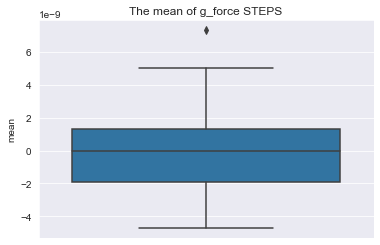

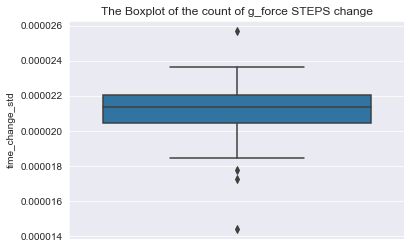

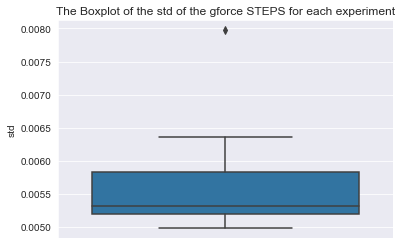

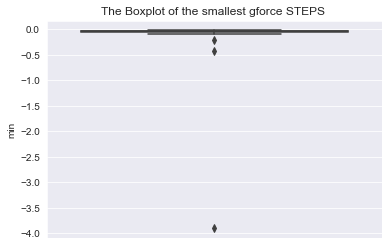

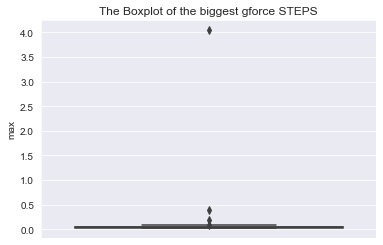

In [96]:
plot_g_force(y=results_gforce_steps_df["mean"], title = 'The mean of g_force STEPS', ptype='box')
plot_g_force(y=results_gforce_steps_df["time_change_std"], title = 'The Boxplot of the count of g_force STEPS change', ptype='box')
plot_g_force(y=results_gforce_steps_df["std"], title = 'The Boxplot of the std of the gforce STEPS for each experiment', ptype='box')
plot_g_force(y=results_gforce_steps_df["min"], title = 'The Boxplot of the smallest gforce STEPS ', ptype='box')
plot_g_force(y=results_gforce_steps_df["max"], title = 'The Boxplot of the biggest gforce STEPS', ptype='box')

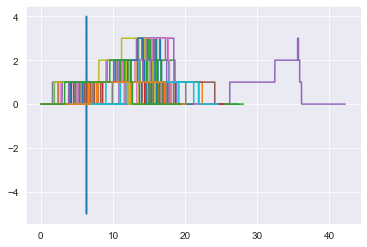

In [32]:


def plot_al_g_force_z_axis():
    for csv in csvs:
        _df = pd.read_csv(csv).copy()
        _df = _df.sort_values(by=['min'])
        _df['G-force_z_axis'] = round(_df['G-force_z_axis'])
        plt.plot(_df['min'].values.tolist(), _df['G-force_z_axis'].values.tolist())



    plt.show()
plot_al_g_force_z_axis()